# COMP90086 Workshop 7

In this workshop, you will have some practice of Hough Transform and Feature matching.

Table of Contents

- Hough Transform
    - How Hough Transform works
    - Implement Hough transform to detect lines

- Feature matching
    - Harris corning detection
    - SIFT
    - FLANN based Matcher
    - Feature matching + homography to find objects
    
- Exercises

In [1]:
## For colab user, run

#! pip install opencv-contrib-python==4.5.2.52

## After the update, You must restart the runtime in order to use newly installed versions.

In [2]:
import os
import numpy as np
import cv2  
from matplotlib import pyplot as plt

# Hough Transform

##  (1) How Hough Transform works

6 mins Introduction Video - "How Hough Transform works"

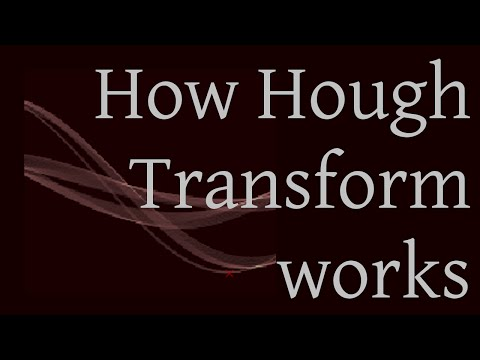

In [3]:
# How Hough Transform works?
# By Thales Sehn Körting (YouTube)

from IPython.display import YouTubeVideo

YouTubeVideo('4zHbI-fFIlI', width=600, height=397)

<center>Implementing a mapping between a Cartesian coordinate system and its parameter space.</center>
<center>y=kx+b --> b=-kx+y</center>
<center>Lines with slope k that do not exist cannot be described under the parameter space (The corresponding lines of M and Z in parameter space are parallel)</center>
<img style="float:  " src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/Hough.png" width=500>

<center>Cartesian coordinates mapped to a parameter space under a polar coordinate system</center>
<center>for each point (x0,y0) --> rθ=x0⋅cosθ+y0⋅sinθ</center>
<center>each pair (rθ,θ) represents each line that passes by (x0,y0).</center>
<img style="float:  " src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/hough_space.png" width=500>

<center>for lines parallel to the X or Y axis can also be well mapped to the parameter space to ensure that they have intersection points</center>
<img style="float:  " src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/hough_a.jpeg" width=500>

## (2) Implement Hough transform to detect lines

First, we detect the edges of the image by using the Canny edge detector.

TypeError: Image data of dtype object cannot be converted to float

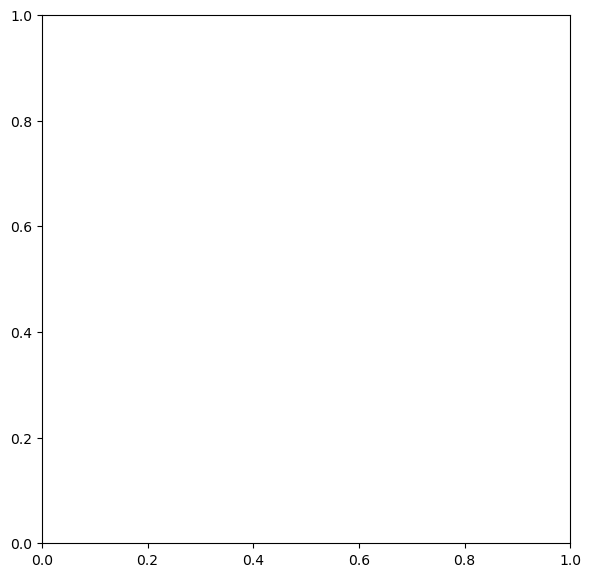

In [4]:
#read in an image from a filepath as graycsale.
rootpath='./'
gray = cv2.imread(os.path.join(rootpath, "canny_im.png"),cv2.IMREAD_GRAYSCALE)

# Canny edge detection with OpenCV
edge_img = cv2.Canny(gray,100,150,apertureSize=3,L2gradient=True) #two thresholds in Hysteresis Thresholding and Aperture size of the Sobel

# Set the Figure size of plotting
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')  
plt.title('Original image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(edge_img, cmap='gray')  
plt.title('Canny edge map')
plt.axis('off')

plt.show() 

Then, we apply Standard Hough Line Transform using the OpenCV functions, cv2.HoughLines(image, rho, theta, threshold) with the following arguments:

- image: Output of the edge detector, a single-channel binary source image.

- rho: The resolution of the parameter ρ in pixels. We use 1 pixel.

- theta: The resolution of the parameter θ in radians. We use 1 degree.

- threshold: The minimum number of intersections to "*detect*" a line. In other words, only those lines are returned that get enough votes (>threshold).


For further understanding, see:
- [Hough Transform](http://homepages.inf.ed.ac.uk/rbf/HIPR2/hough.htm).
- [cv2.HoughLines( )](https://docs.opencv.org/4.5.2/dd/d1a/group__imgproc__feature.html#ga46b4e588934f6c8dfd509cc6e0e4545a)

<img style="float:  " src="https://docs.opencv.org/4.5.2/Hough_Lines_Tutorial_Theory_0.jpg" width=300>
(Image source: OpenCV)

**Change the threshold and see what happens!**

In [ ]:
thres = 200

In [ ]:
#Implement Hough transform to detect lines in a Canny edge map 

# Finds lines in a binary image using the standard Hough transform
lines = cv2.HoughLines(edge_img, 1, np.pi/180, thres)  
# This function outputs vector of detected lines. 
# Each line is represented by a vector (ρ,θ). 
# Whereas ρ/rho is the distance from the coordinate origin (0,0) 
# and θ/theta is the line rotation angle in radians ( 0∼vertical line,π/2∼horizontal line ).

Now, we display the result by drawing detected lines on the original image

In [ ]:
# (Optional) To better distinguish the detected lines from the background, 
# we will draw the lines in colour. 
# Therefore, we first convert the grayscale map to RGB format.
color_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB) 

# Display by drawing the lines
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    pt1 = (int(x0 + 1000*(-b)),int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)),int(y0 - 1000*(a)))
    # Draws a line segment connecting two points, colour=(255,0,0) and thickness=2.
    cv2.line(color_img,pt1,pt2,(255,0,0),2)

plt.imshow(color_img) 
plt.title("Detected Lines (in red)")
plt.axis('off')

plt.show() 

# Feature matching

Corners (E and F) are easier to isolate and locate in the image than other features, which makes them better features to detect. 

(Image: A. Mordvintsev and A. K. Revision). 
<img style="float: " src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/building_corner.jpeg" width=500>

<img style="float: " src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/corner.jpeg" width=500>
(Image: Moravec 1980)

Corners are the important features in the image, and they are generally termed as interest points which are invariant to translation, rotation, and illumination.

## (1) Harris corner detection

We apply Harris Corner Detection using the OpenCV functions, cv2.cornerHarris(image, blockSize, ksize, k) with the following arguments:

- img: A single-channel float32 input image.
- blockSize: Neighborhood size for corner detection.
- ksize: Aperture parameter for the Sobel operator.
- k: Harris detector free parameter in the equation. Often between 0.04 and 0.06.

For further understanding, see:
- [cv2.cornerHarris( )](https://docs.opencv.org/4.5.2/dc/d0d/tutorial_py_features_harris.html)

In [ ]:
# Read in an image from a filepath as graycsale.
rootpath='./'
img = cv2.imread(os.path.join(rootpath, "central.png"))

# detector parameters
block_size = 2
sobel_size = 3
k = 0.04

# Convert the colour from BGR to RGB for display
color_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Convert the colour to grayscale & 32-bit float
gray_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray_img = np.float32(gray_img)

# Detect corners with custom detector parameters
dst = cv2.cornerHarris(gray_img, block_size, sobel_size, k)

# Dilate corner image to enhance corner points, not necessary
#kernel = np.ones((3, 3), np.uint8) # The larger the size of the kernel, the greater the dilation
#dst = cv2.dilate(dst, kernel)
# Try to run the above codes to see what happens on the “Detected corners” map.

# Create a copy of the image and draw corners on it
corner_image = np.copy(color_img)

# Vary the threshold according to the image and the number of corners you want to detect
# The corners are drawn on the image if they pass the threshold
thresh = 0.1
corner_image[dst>thresh*dst.max()]=[0,255,0] # marking the corners in Green
# Try to change the threshold to see what happens.

plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(color_img)
plt.title('Original image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(dst, cmap='gray')  
plt.title('Detected corners')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(corner_image)
plt.title('Display strong corners on the original image')
plt.axis('off')

plt.show() 

## (2) SIFT

#### Harris corner detection is not scale invariant, so it is not applicable when the scale of the image changes. To find scale-invariant features, an algorithm called Scale Invariant Feature Transform (SIFT) was proposed by D.Lowe.

<img style="float: " src="https://miro.medium.com/max/1400/1*nkJt5BX6WJEDbVAl-fOE0A.png" width=500>

(Image Source: These images appears in many places, including [here](https://medium.com/jun94-devpblog/cv-12-scale-invariant-local-feature-extraction-2-harris-laplace-170d48ee1bf1))

Harris corner point detection is rotationally invariant, but not scale invariant. As shown in the figure below, corner points at small scales may be assumed to be edges when they are zoomed in.


For further understanding, see:
- [SIFT](https://docs.opencv.org/4.5.2/da/df5/tutorial_py_sift_intro.html)

More information on the functions used below, see:
- [cv2.pyrDown( )](https://docs.opencv.org/4.5.2/d4/d86/group__imgproc__filter.html#gaf9bba239dfca11654cb7f50f889fc2ff)
- [cv2.getRotationMatrix2D( )](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#gafbbc470ce83812914a70abfb604f4326)
- [cv2.warpAffine( )](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#ga0203d9ee5fcd28d40dbc4a1ea4451983)
- [cv2.drawKeypoints( )](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920)

In [ ]:
# Check your cv2 version
cv2.__version__  
# Note that these were previously only available in the opencv contrib repo, 
# but the patent expired in the year 2020. So they are now included in the main repo. 

# For those who are using OpenCV versions released before 2020 (e.g. cv2.__version__ == 4.2.x ), 
# they might got "AttributeError: module 'cv2' has no attribute 'SIFT_create' ".  

# To solve this problem, one possible solution is to uninstall Anaconda and reinstall to the latest version.
# Then follow the Week 1 guide “Getting set up for workshops”

Display original image and scene image

In [ ]:
# Read in images from a filepath as graycsale.
rootpath='./'
gray = cv2.imread(os.path.join(rootpath, 'box.png'),cv2.IMREAD_GRAYSCALE)
scene_gray = cv2.imread(os.path.join(rootpath, 'box_in_scene.png'),cv2.IMREAD_GRAYSCALE)

# Optional: Create a modified image by adding scale invariance and rotation invariance

#scene_gray = cv2.pyrDown(gray) #blurs an image and downsamples it
#rows, cols = scene_gray.shape[:2] #in case this is not a greyscale image
#rotation_matrix = cv2.getRotationMatrix2D((cols/2, rows/2), 45, 1) #calculate an affine matrix of 2D rotation
#scene_gray = cv2.warpAffine(scene_gray, rotation_matrix, (cols, rows)) #apply an affine transformation to image


# Display original image and scene image
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')  
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(scene_gray, cmap='gray')  
plt.title('Scene Image')
plt.axis('off')

plt.show() 

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(gray,None)
kp2, des2 = sift.detectAndCompute(scene_gray,None)

# Draws the small circles on the locations of keypoints without size
kp1_without_size = cv2.drawKeypoints(gray,kp1,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(scene_gray,kp2,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(gray,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(scene_gray,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display images with&without the size of keypoints 
plt.subplots(figsize=(15, 10)) 

plt.subplot(2,2,1)
plt.imshow(kp1_without_size, cmap='gray')  
plt.title('Original Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(kp2_without_size, cmap='gray')  
plt.title('Scene Image keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Original Image keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Scene Image keypoints with size')
plt.axis('off')

plt.show() 

# Print the number of keypoints detected
print("Number of keypoints detected in the original image: ", len(kp1))
print("Number of keypoints detected in the Scene image: ", len(kp2))

#### Now we've got the keypoints, descriptors and so on. Now we are going to see how to match keypoints in different images.

## (3) FLANN based Matcher

#### FLANN (Fast Library for Approximate Nearest Neighbors) contains a collection of algorithms optimized for fast nearest neighbor search in large datasets and for high dimensional features. 

When performing matching, the KNN algorithm is generally used to find the two nearest neighbours. If the ratio between the closest and second closest is greater than a given value, then we keep this closest value and consider it and its matching point as a good match.

For further understanding, see:

- [FLANN based Matcher](https://docs.opencv.org/4.5.2/dc/dc3/tutorial_py_matcher.html#flann-based-matcher)

More information on the functions used below, see:

- [FlannBasedMatcher Class Reference](https://docs.opencv.org/4.5.2/dc/de2/classcv_1_1FlannBasedMatcher.html)
- [cv2.drawMatchesKnn( )](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a)

In [ ]:
# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
        
# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(gray,kp1,scene_gray,kp2,matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))

## (4) Feature matching + homography to find objects

We have found a number of matching points in two images by following the steps above. How do we align one of the images with the other by rotating, transforming, etc.? This is where the homography matrix comes into play.

The homography matrix has eight parameters. Since each corresponding pixel point can generate 2 equations (one x, one y), then only a minimum of four pixel points are enough to solve the Homography matrix.


More information on the functions used below, see:

- [cv2.findHomography( )](https://docs.opencv.org/4.5.2/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780)

- [cv2.warpPerspective( )](https://docs.opencv.org/4.5.2/da/d54/group__imgproc__transform.html#gaf73673a7e8e18ec6963e3774e6a94b87)

- [cv2.drawMatches( )](https://docs.opencv.org/4.5.2/d4/d5d/group__features2d__draw.html#gad8f463ccaf0dc6f61083abd8717c261a)

In [ ]:
# Now we set a condition that at least N matches (defined by MIN_MATCH_NUM) are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)>= MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 10) # try to change maxIters and see the effect
    # Where H is the resulting single-strain matrix.
    # status returns a list of feature points that represent successful matches.
    # ptsA, ptsB are keypoints.
    # The three parameters cv2.RANSAC, ransacReprojThreshold, maxIters are related to RANSAC.
    # ransacReprojThreshold: Maximum reprojection error in the RANSAC algorithm to consider a point as an inlier. 
    # maxIters: The maximum number of RANSAC-based robust method iterations.
    
    success = status.ravel().tolist()
    
    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(scene_gray, H, (gray.shape[1],gray.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", success.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    success = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = success, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(gray,kp1,scene_gray,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(15, 15)) 

if success == None:
    plt.imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    plt.imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    plt.imshow(imgOut, 'gray')
    plt.title('Display detected template in scene image')
    plt.axis('off')

plt.show()

# Exercise

## Exercise 1

- Implement Canny edge detection and Hough transform to detect the grid in the checkerboard.
- Change the threshold of the HoughLines function. What happens as you increase/decrease the threshold?

In [ ]:
# Read in an image from a filepath as graycsale.
rootpath='./'
checkerboard = cv2.imread(os.path.join(rootpath, "checkerboard.png"),cv2.IMREAD_GRAYSCALE)

In [ ]:
# your code

### Exercise 1 Solution

Answer: fewer/more lines (but with lower thresholds, the lines may be worse, since they will be accepted with fewer "votes")

The code here is only a reference solution. The aim of the exercise is to understand the effect of different parameters on the results. Different parameters are accepted.

In [ ]:
# Canny edge detection with OpenCV
board_edge = cv2.Canny(checkerboard,50,250,apertureSize=3,L2gradient=True)

# Sandard Hough transform
lines = cv2.HoughLines(board_edge, 1, np.pi/180, 120)  

# Convert the grayscale map to RGB format.
color_board = cv2.cvtColor(checkerboard, cv2.COLOR_GRAY2RGB)

# Drawing the lines
for line in lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    pt1 = (int(x0 + 1000*(-b)),int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)),int(y0 - 1000*(a)))
    # Draws a line segment connecting two points, colour=(255,0,0) and thickness=2.
    cv2.line(color_board,pt1,pt2,(255,0,0),2)

                                                  
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,3,1)
plt.imshow(checkerboard, cmap='gray')  
plt.title('Original image')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(board_edge, cmap='gray')  
plt.title('Canny edge map')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(color_board) 
plt.title("Detected Lines (in red)")
plt.axis('off')

plt.show() 

## Exercise 2

- Use SIFT+RANSAC to match the close-up views of buildings to the larger scenes. Note that this may require changing the ratio used in the Lowe's ratio test step of FLANN matcher and/or the maxIters parameter of the RANSAC step. 
- What is the effect of changing these parameters?

In [ ]:
# Read in close-up views of buildings images and the larger scenes images as graycsale.
rootpath='./'
flinders1 = cv2.imread(os.path.join(rootpath, "flinders1.png"),cv2.IMREAD_GRAYSCALE) 
flinders2 = cv2.imread(os.path.join(rootpath, "flinders2.png"),cv2.IMREAD_GRAYSCALE) 
unimelb1 = cv2.imread(os.path.join(rootpath, "unimelb1.png"),cv2.IMREAD_GRAYSCALE)
unimelb2 = cv2.imread(os.path.join(rootpath, "unimelb2.png"),cv2.IMREAD_GRAYSCALE)

# Display original image and scene image
plt.subplots(figsize=(10, 10)) 

plt.subplot(2,2,1)
plt.imshow(flinders1, cmap='gray')  
plt.title('Close-up views of Flinders Station ')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(flinders2, cmap='gray')  
plt.title('Larger scenes of Flinders Station')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(unimelb1, cmap='gray')  
plt.title('Close-up views of Unimelb Old Arts Clock Tower')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(unimelb2, cmap='gray')  
plt.title('Larger scenes of Unimelb Old Arts Clock Tower')
plt.axis('off')

plt.show() 

### Exercise 2 Solution

Answer: Both of these are a bit more difficult than the box scene, so they may require a different ratio (which changes the number of good matches and percentage of false matches). They may also require a higher number of RANSAC iterations to find a correct solution.

The code here is only a reference solution. The aim of the exercise is to understand the effect of changing these parameters. Different parameters are accepted.

Flinders Station

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(flinders1,None)
kp2, des2 = sift.detectAndCompute(flinders2,None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Store all good matches as per Lowe's Ratio test.
ratio = 0.6
good = []
for m,n in matches:
    if m.distance < ratio*n.distance:
        good.append(m)

# Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)> MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 500)

    matchesMask = status.ravel().tolist()

    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(flinders2, H, (flinders1.shape[1],flinders1.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", matchesMask.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    matchesMask = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(matchColor = (0,255,0), # draw in a specific colour
                   singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(flinders1,kp1,flinders2,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(10, 10)) 

if matchesMask == None:
    plt.imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    plt.imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    plt.imshow(imgOut, 'gray')
    plt.title('Display detected template in scene image')
    plt.axis('off')

plt.show()

Unimelb Old Arts Clock Tower

In [ ]:
# Initiate SIFT detector
sift = cv2.SIFT_create() # if cv2 version >= 4.4.0 
# sift = cv2.xfeatures2d.SIFT_create() # if cv2 version = 4.3.x 

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(unimelb1,None)
kp2, des2 = sift.detectAndCompute(unimelb2,None)

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Store all good matches as per Lowe's Ratio test.
good = []
for m,n in matches:
    if m.distance < 0.8*n.distance:
        good.append(m)

# Set a condition that at least MIN_MATCH_NUM matches are required to find the object. 
MIN_MATCH_NUM = 4

if len(good)> MIN_MATCH_NUM:
    # If enough matches are found, we extract the positions of the matched keypoints in both images. 
    # They are passed to find the perspective transformation. 
    
    # Estimate homography between two images
    ptsA = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
    ptsB = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1,1,2)
    H, status = cv2.findHomography(ptsA, 
                                   ptsB, 
                                   cv2.RANSAC, 
                                   ransacReprojThreshold = 5, 
                                   maxIters = 200)

    matchesMask = status.ravel().tolist()

    # Draw detected template in scene image
    imgOut = cv2.warpPerspective(unimelb2, H, (unimelb1.shape[1],unimelb1.shape[0]),
                             flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP)
    
    # Print total number of successful matches between two images
    print("\nNumber of successful matches between two images: ", matchesMask.count(1)) # Returns the number of 1 in the success list

else:
    # Otherwise, print that “Not enough matches are found”.
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_NUM) )
    matchesMask = None


# Draw our inliers (if successfully found the object) or all matching keypoints (if failed)
draw_params = dict(#matchColor = (0,255,0), # draw in a specific colour
                   #singlePointColor = (255,0,0), # draw in a specific colour
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)

success_matches = cv2.drawMatches(unimelb1,kp1,unimelb2,kp2,good,None,**draw_params)


# Plotting results
plt.subplots(figsize=(10, 10)) 

if matchesMask == None:
    plt.imshow(success_matches)
    plt.title('All matching keypoints')
    plt.axis('off')
    
else:
    plt.subplot(2,1,1)
    plt.imshow(success_matches)
    plt.title('All successful matches')
    plt.axis('off')
    
    plt.subplot(2,1,2)
    plt.imshow(imgOut, 'gray')
    plt.title('Display detected template in scene image')
    plt.axis('off')

plt.show()

## Exercise 3


- Implement the RANSAC algorithm step by step by filling in the three main steps of the RANSAC loop

### Exercise 3 Solution

Adapted from: https://salzis.wordpress.com/2014/06/10/robust-linear-model-estimation-using-ransac-python-implementation/

Set up the dataset:

In [ ]:
import math
import sys
 
# Ransac parameters
ransac_iterations = 20  # number of iterations
ransac_threshold = 3    # threshold
ransac_ratio = 0.6      # ratio of inliers required to assert
                        # that a model fits well to data

# generate sparse input data
n_samples = 500               # number of input points
outliers_ratio = 0.4          # ratio of outliers
 
n_inputs = 1
n_outputs = 1
 
# generate samples
x = 30*np.random.random((n_samples,n_inputs) )
 
# generate line's slope (called here perfect fit)
perfect_fit = 0.5*np.random.normal(size=(n_inputs,n_outputs) )
 
# compute output
y = np.dot(x,perfect_fit)

# add a little gaussian noise
x_noise = x + np.random.normal(size=x.shape)
y_noise = y + np.random.normal(size=y.shape)
 
# add some outliers to the point-set
n_outliers = round(outliers_ratio*n_samples)
indices = np.arange(x_noise.shape[0])
np.random.shuffle(indices)
outlier_indices = indices[:n_outliers]
 
x_noise[outlier_indices] = 30*np.random.random(size=(n_outliers,n_inputs))
 
# gaussian outliers
y_noise[outlier_indices] = 30*np.random.normal(size=(n_outliers,n_outputs))

These two functions will be called by the RANSAC loop: `find_line_model()` fits a line to sample points and `dist_to_line()` computes the distance from a sample point to the closest point on a line.

In [ ]:
def find_line_model(points):
    """ find a line model for the given points
    :param points selected points for model fitting
    :return line model
    """
 
    # [WARNING] vertical and horizontal lines should be treated differently
    #           here we just add some noise to avoid division by zero
 
    # find a line model for these points
    m = (points[1,1] - points[0,1]) / (points[1,0] - points[0,0] + sys.float_info.epsilon)  # slope (gradient) of the line
    c = points[1,1] - m * points[1,0]                                     # y-intercept of the line
 
    return m, c

def find_dist_to_line(m, c, x0, y0):
    """ find an intercept point of the line model with
        a normal from point (x0,y0) to it, return
        distance betwee point (x0, y0) and intercept
    :param m slope of the line model
    :param c y-intercept of the line model
    :param x0 point's x coordinate
    :param y0 point's y coordinate
    :return intercept point
    """
 
    # intersection point with the model
    x = (x0 + m*y0 - m*c)/(1 + m**2)
    y = (m*x0 + (m**2)*y0 - (m**2)*c)/(1 + m**2) + c
    dist = math.sqrt((x - x0)**2 + (y - y0)**2)
 
    return dist

A function for plotting the RANSAC iterations:

In [ ]:
def ransac_plot(n, x, y, m, c, x_in=(), y_in=(), points=()):
    """ plot the current RANSAC step
    :param n      iteration
    :param x      samples x
    :param y      samples y
    :param m      slope of the line model
    :param c      shift of the line model
    :param x_in   inliers x
    :param y_in   inliers y
    :param points picked up points for modeling
    """

    line_width = 1.
    line_color = '#0080ff'
    title = 'iteration ' + str(n)

    plt.figure(figsize=(5,5))

    # plot input points
    plt.plot(x[:,0], y[:,0], marker='o', label='Input points', color='#00cc00', linestyle='None', alpha=0.4)
 
    # draw the current model
    plt.plot(x, m*x + c, 'r', label='Line model', color=line_color, linewidth=line_width)
 
    # draw inliers, if provided
    if len(x_in) > 0:
        plt.plot(x_in, y_in, marker='o', label='Inliers', linestyle='None', color='#ff0000', alpha=0.6)
 
    # draw points picked up for the modeling, if provided
    if len(points) > 0:
        plt.plot(points[:,0], points[:,1], marker='o', label='Picked points', color='#0000cc', linestyle='None', alpha=0.6)
 
    plt.title(title)
    plt.legend()
    plt.show()

The main RANSAC loop:

In [ ]:
data = np.hstack( (x_noise,y_noise) )
 
ratio = 0.
model_m = 0.
model_c = 0.
 
# perform RANSAC iterations
for it in range(ransac_iterations):
 
    # randomly sample N points
    n = 2
 
    all_indices = np.arange(x_noise.shape[0])
    np.random.shuffle(all_indices)
 
    indices_1 = all_indices[:n]
    indices_2 = all_indices[n:]
 
    sample_points = data[indices_1,:]
    test_points = data[indices_2,:]
 
    # fit a line model to the sampled points
    m, c = find_line_model(sample_points)
 
    x_list = []
    y_list = []
    num = 0

    # count the number of inliers num
    # inliers are points whose distance to the line is less than ransac_threshold
    for ind in range(test_points.shape[0]):
 
        x0 = test_points[ind,0]
        y0 = test_points[ind,1]
 
        # find an intercept point of the model with a normal from point (x0,y0)
        dist = find_dist_to_line(m, c, x0, y0)
 
        # check whether it's an inlier or not
        if dist < ransac_threshold:
            x_list.append(x0)
            y_list.append(y0)
            num += 1
 
    x_inliers = np.array(x_list)
    y_inliers = np.array(y_list)
 
    # if this value of num is higher than previously saved value,
    # save it, and save the current model parameters
    if num/float(n_samples) > ratio:
        ratio = num/float(n_samples)
        model_m = m
        model_c = c
 
    print('   inlier ratio = ', num/float(n_samples))
    print('  model_m = ', model_m)
    print('  model_c = ', model_c)
 
    # plot the current step with inliers and sample points
    ransac_plot(it, x_noise, y_noise, m, c, x_inliers, y_inliers, sample_points)
    # plot the current step without showing inliers or sample points
    #ransac_plot(0, x_noise, y_noise, model_m, model_c)
 
    # we are done in case we have enough inliers
    if num > n_samples*ransac_ratio:
        print('The model is found !')
        break

# plot the final model
ransac_plot(0, x_noise, y_noise, model_m, model_c)
 
print('\nFinal model:\n')
print('  ratio = ', ratio)
print('  model_m = ', model_m)
print('  model_c = ', model_c)

## Exercise 4

<img style="float:" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/ball.png" width=300>
<img style="float:" src="https://raw.githubusercontent.com/saraao/COMP90086_image/main/ball2.png" width=300>

An application needs to find a circle of unknown size in an image. It operates as follows:

1. Detect edges
2. RANSAC:\
    (1)	Sample 3 edge points  
    (2) Fit a circle to those three points (three is enough to uniquely fit a circle)\
    (3)	Count consensus
    
3. Report circle with maximum consensus
    
i) If the circle in the image has 10% of the edge pixels, calculate how many RANSAC iterations are needed to find it with 99% probability.

A: log(0.01)/log(0.999) = 4603

ii) How might the algorithm be modified to improve the accuracy of the estimated centre and radius of the circle?

A: Re-estimate using all inliers.